In [ ]:
!nvidia-smi -L
folder = '/content/gdrive/MyDrive/ChessDL/1-Data/'

validThemes = set(['capturingDefender',  'discoveredAttack', 'fork',
       'hangingPiece', 'mateIn1', 'pin', 'sacrifice', 'skewer',
       'trappedPiece'])

GPU 0: Tesla V100-SXM2-16GB (UUID: GPU-8a6acda4-1546-94d6-11e1-0f32feeb9b0e)


In [ ]:
!pip install -Uq fastai
import seaborn as sns
import matplotlib.pyplot as plt
import chess
import numpy as np
import os
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import fastai

from fastai.data.all import *
from fastai.vision.all import *
from fastai.callback.hook import *

from google.colab import drive 
drive.mount('/content/gdrive/', force_remount=True) 

Mounted at /content/gdrive/


# Initial Tactics Data Processing

In [ ]:
# download the tactics
tactics_path = folder+'tactics.csv.bz2'
download_url('https://database.lichess.org/lichess_db_puzzle.csv.bz2', tactics_path)

# and normal games (smaller file only 250MB)
game_path = folder+'games.pgn.bz2'
download_url('https://database.lichess.org/standard/lichess_db_standard_rated_2013-05.pgn.bz2', game_path)


In [ ]:
def decompress(filepath):
  zipfile = bz2.BZ2File(filepath) # open the file
  data = zipfile.read() # get the decompressed data
  newfilepath = filepath[:-4] # assuming the filepath ends with .bz2
  open(newfilepath, 'wb').write(data) # write a uncompressed file

# and decompress the files
decompress(game_path)
decompress(tactics_path)

First filter out puzzles that are unwanted. See here for description by theme name:

https://github.com/ornicar/lila/blob/master/translation/source/puzzleTheme.xml

In [ ]:
def getFirstValid(themes):
  valid =   list(filter(lambda x: x in validThemes, themes))
  return (valid[0] if len(valid) >0 else '')

def getValid(themes):
  valid =   list(filter(lambda x: x in validThemes, themes))
  return (" ".join(valid) if len(valid) >0 else 'None')


corpusDf = pd.read_csv('/content/gdrive/MyDrive/ChessDL/1-Data/tactics.csv', header=None, names=['PuzzleId','FEN','Moves','Rating','RatingDeviation','Popularity','NbPlays','Themes','GameUrl'])
df = corpusDf[['PuzzleId','FEN','Themes','Rating']]
df['Themes'] = df['Themes'].map(lambda x: getValid(x.split(' ')))

df.to_csv(folder+'1-parsedTactics.csv')
print(len(df))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


1102218


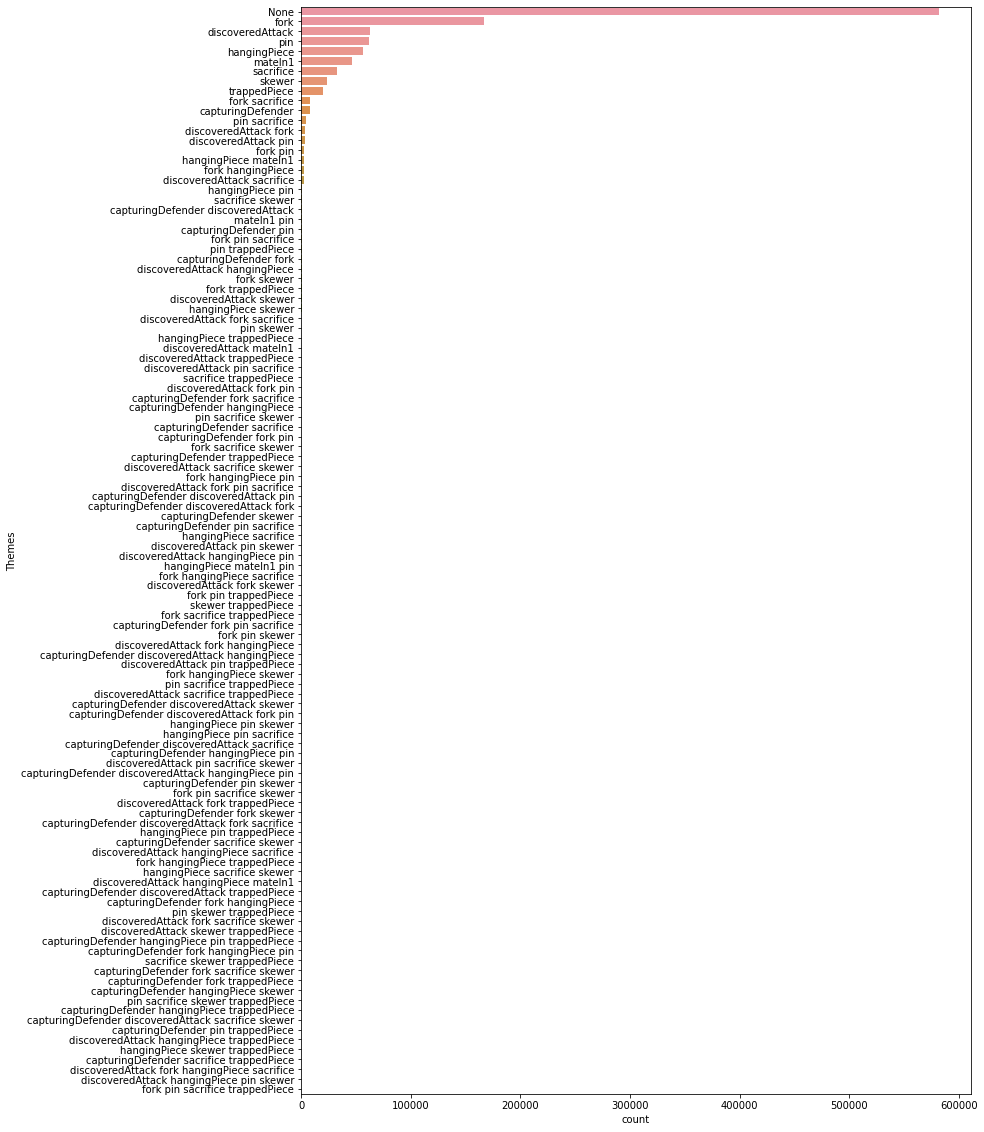

In [ ]:
# Let's check out the relative class sizes

def pltFreq(df):
  ct = df.groupby('Themes')['FEN'].count().reset_index().rename(columns={'FEN':'count'})
  fig, ax= plt.subplots(figsize=(12,20))
  sns.barplot(y="Themes", x="count",  data=ct.sort_values('count',ascending=False), ax=ax)

pltFreq(df)

In [ ]:
df.groupby('Themes').count()['FEN'].sort_values()

Themes
capturingDefender fork hangingPiece pin             1
capturingDefender sacrifice trappedPiece            1
hangingPiece skewer trappedPiece                    1
capturingDefender hangingPiece trappedPiece         1
capturingDefender hangingPiece skewer               1
                                                ...  
hangingPiece                                    56654
pin                                             62012
discoveredAttack                                63021
fork                                           166551
None                                           581711
Name: FEN, Length: 110, dtype: int64

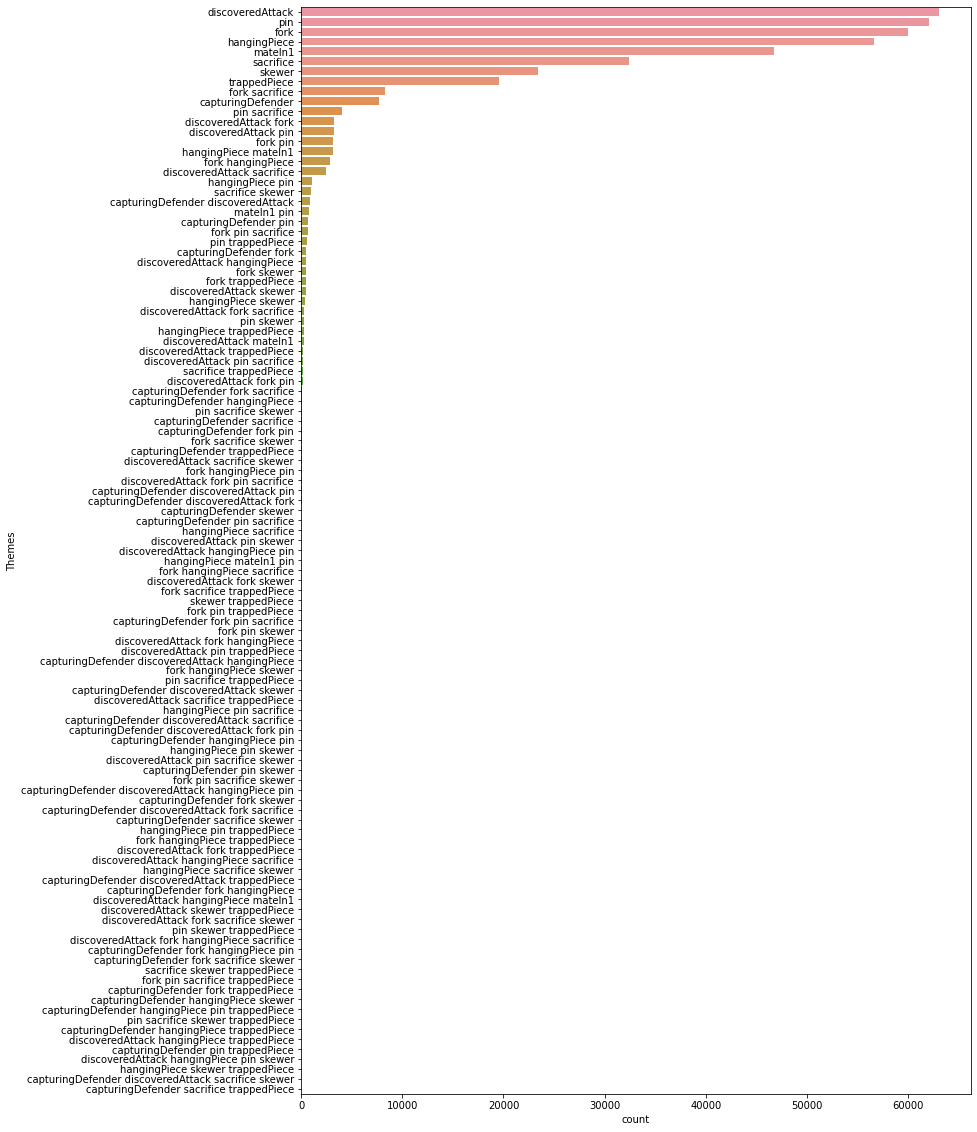

In [ ]:
df = df[df['Themes']!='None']#.append(df[df['Themes']=='fork'][0:60000]) # cut these out
df = df[df['Themes']!='fork'].append(df[df['Themes']=='fork'][0:60000]) # cut down here
df.to_csv(folder+'2-sampled.csv')
pltFreq(df)

In [ ]:
df = pd.read_csv(folder+'2-sampled.csv')
df = df[['PuzzleId','FEN','Themes']]
df.groupby('Themes').count()['FEN'].sort_values()

Themes
discoveredAttack hangingPiece trappedPiece        1
capturingDefender fork trappedPiece               1
capturingDefender hangingPiece skewer             1
capturingDefender fork sacrifice skewer           1
discoveredAttack hangingPiece pin skewer          1
                                              ...  
mateIn1                                       46736
hangingPiece                                  56654
fork                                          60000
pin                                           62012
discoveredAttack                              63021
Name: FEN, Length: 109, dtype: int64

In [ ]:
# ensure no data leakage (hash on FEN so that they end up in the same set)
df['is_valid'] = df['PuzzleId'].apply(lambda x: hash(x) %10 >= 8) # 20%

df.to_csv(folder +'3a-train.csv')
df.groupby('is_valid').count()/len(df)

,PuzzleId,FEN,Themes
is_valid,,,
False,0.801049,0.801049,0.801049
True,0.198951,0.198951,0.198951


# Data Loader

In [ ]:
chess_dict = {
    'p' : [1,0,0,0,0,0,0,0,0,0,0,0],
    'P' : [0,0,0,0,0,0,1,0,0,0,0,0],
    'n' : [0,1,0,0,0,0,0,0,0,0,0,0],
    'N' : [0,0,0,0,0,0,0,1,0,0,0,0],
    'b' : [0,0,1,0,0,0,0,0,0,0,0,0],
    'B' : [0,0,0,0,0,0,0,0,1,0,0,0],
    'r' : [0,0,0,1,0,0,0,0,0,0,0,0],
    'R' : [0,0,0,0,0,0,0,0,0,1,0,0],
    'q' : [0,0,0,0,1,0,0,0,0,0,0,0],
    'Q' : [0,0,0,0,0,0,0,0,0,0,1,0],
    'k' : [0,0,0,0,0,1,0,0,0,0,0,0],
    'K' : [0,0,0,0,0,0,0,0,0,0,0,1],
    '.' : [0,0,0,0,0,0,0,0,0,0,0,0],
}

def piece2idx(piece):
  x = 7-chess.square_rank(piece)
  y = chess.square_file(piece)
  return (x,y)

def fen2tnsr(fen):
  board = chess.Board(fen)

  # make the board (8x8x25 = [12 currpiece, 12 inbound, 1 who's move])
  turn = np.ones(1) if fen.split(' ')[1] != 'w' else np.zeros(1)
  sq = np.append(np.zeros(24),turn).reshape(1,25)
  boardHeat = np.tile(sq,8*8).reshape(8,8,25)

  for idx in board.piece_map():
    sym = board.piece_at(idx).symbol()
    baseVec = np.array(chess_dict.get(sym))

    attackVec = np.zeros(12)
    for attack in board.attackers(True, idx): attackVec += chess_dict.get(board.piece_at(attack).symbol()) # attackers
    for attack in board.attackers(False, idx): attackVec += chess_dict.get(board.piece_at(attack).symbol()) # defenders

    # add the two vectors together
    vec = np.append(baseVec, attackVec)
    vec = np.append(vec, turn) # add bit of turn feature

    boardHeat[piece2idx(idx)] = vec #save it

  boardHeat = boardHeat.transpose(2,0,1)
  boardHeat = torch.from_numpy(boardHeat)
  return(boardHeat) # move channels first, so 25 x 8 x 8

In [ ]:
def get_x(r): return (fen2tnsr(r['FEN']))
def get_ys(r): return r['Themes'].split(' ')
def get_y(r): return r['Theme']

def getDls(df, targetLabel=None):
  weight = None
  dblock = DataBlock(blocks=(TransformBlock, MultiCategoryBlock), get_x = get_x, get_y = get_ys)

  if targetLabel is not None:
    df['Theme'] = df['Themes'].apply(lambda x: targetLabel if targetLabel in x else 'None')
    weight = len(df)/np.array(df.groupby('Theme')['FEN'].count().tolist())
    dblock = DataBlock(blocks=(TransformBlock, CategoryBlock), get_x = get_x, get_y = get_y)
  
  dsets = dblock.datasets(df)
  dls = dblock.dataloaders(df)
  # dls.bs= 512

  return(weight, dsets, dls)

df = pd.read_csv(folder+'3a-train.csv')
wt, dsets, dls = getDls(df)
dsets.train.vocab

['capturingDefender', 'discoveredAttack', 'fork', 'hangingPiece', 'mateIn1', 'pin', 'sacrifice', 'skewer', 'trappedPiece']

In [ ]:
class ConvBlock(nn.Module):
    def __init__(self):
        super(ConvBlock, self).__init__()
        # self.action_size = 7
        self.conv1 = nn.Conv2d(25, 256, 3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(256)

    def forward(self, s):
        s = s.view(-1, 25, 8, 8)  # batch_size x channels x board_x x board_y
        s = F.relu(self.bn1(self.conv1(s)))
        return s

In [ ]:
class ResBlock(nn.Module):
    def __init__(self, inplanes=256, planes=256, stride=1, downsample=None):
        super(ResBlock, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = F.relu(self.bn1(out))
        out = self.conv2(out)
        out = self.bn2(out)
        out += residual
        out = F.relu(out)
        return out

In [ ]:
class OutBlock(nn.Module):
    def __init__(self, n_classes):
        super(OutBlock, self).__init__()
        self.conv = nn.Conv2d(256, 12, kernel_size=1) # value head
        self.bn = nn.BatchNorm2d(12)
        self.fc1 = nn.Linear(12*8*8, 32)
        self.fc2 = nn.Linear(32, n_classes)
    
    def forward(self,s):
        v = F.relu(self.bn(self.conv(s))) # value head
        v = v.view(-1, 12*8*8)  # batch_size X channel X height X width
        v = F.relu(self.fc1(v))
        v = torch.sigmoid(self.fc2(v)) # if multi-class

        return v

In [ ]:
class ChessNet(nn.Module):
    def __init__(self, n_classes):
        super(ChessNet, self).__init__()
        self.conv = ConvBlock()
        for block in range(2):
            setattr(self, "res_%i" % block,ResBlock())
        self.outblock = OutBlock(n_classes)
    
    def forward(self,s):
        s = s.float()
        s = self.conv(s)
        for block in range(2):
            s = getattr(self, "res_%i" % block)(s)
        s = self.outblock(s)
        return s

/usr/local/lib/python3.7/dist-packages/fastai/callback/core.py:50: UserWarning: You are shadowing an attribute (modules) that exists in the learner. Use `self.learn.modules` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


SuggestedLRs(lr_min=0.03630780577659607, lr_steep=0.0030199517495930195)

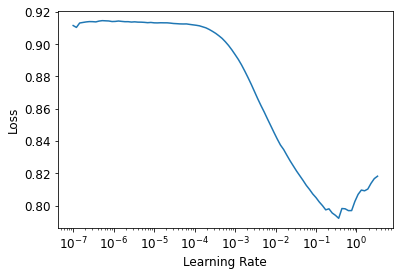

In [ ]:
def getLearner(dls, wt=None):
  learn = Learner(dls, ChessNet(n_classes=len(validThemes)),  opt_func = partial(Adam, decouple_wd=False), wd=0.01, metrics=accuracy_multi, model_dir=folder+ '/models/', cbs=[ActivationStats(with_hist=True), GradientClip(.3), MixedPrecision()])

  if wt is not None:
    class_weights=torch.FloatTensor(wt).cuda()
    learn.loss_func = nn.CrossEntropyLoss(weight=class_weights)

  return learn

learn = getLearner(dls)
learn.lr_find()

In [ ]:
learn.fit_one_cycle(1, 3e-3)